The goal of this notebook is to check the performance of various formulations

In [1]:
using Pkg; Pkg.activate()
using Runner, Zoo, Serialization, nGraph, JuMP, Plots

┌ Info: Recompiling stale cache file /home/mark/.julia/compiled/v1.1/Runner/F5BZU.ji for Runner [4a6e9825-ed04-540b-82d3-f33d0e8d45fb]
└ @ Base loading.jl:1184
┌ Warning: Package Runner does not have Serialization in its dependencies:
│ - If you have Runner checked out for development and have
│   added Serialization as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Runner
└ Loading Serialization into Runner from project dependency, future warnings for Runner are suppressed.


In [6]:
#=
f = () -> Zoo.vgg19_training(128)
nsteps = 5

# Generator functions for the various optimization methods
simple(n) = function(data)
    bounds = Runner.allocation_bounds(data)
    x = round(Int, bounds.upper_bound * n / 1E6)
    return Runner.Simple(x)
end

synchronous(n) = function(data)
    bounds = Runner.allocation_bounds(data)
    x = round(Int, bounds.upper_bound * n / 1E6)
    return Runner.Synchronous(x, 29000, 12000)
end

# Fractions of the dram limit to use
r = exp10.(range(0, 1; length = nsteps))
r = r .- minimum(r)
fractions = r ./ maximum(r)

simple_iter = simple.(fractions)
synchronous_iter = synchronous.(fractions)

#simple_data = Runner.compare(f, simple_iter; statspath = "serials/vgg19_128_simple.jls")
synchronous_data = Runner.compare(f, synchronous_iter; statspath = "serials/vgg19_128_synchronous.jls")
=#

Processing 1 of 5
Found 38 params


InterruptException: InterruptException:

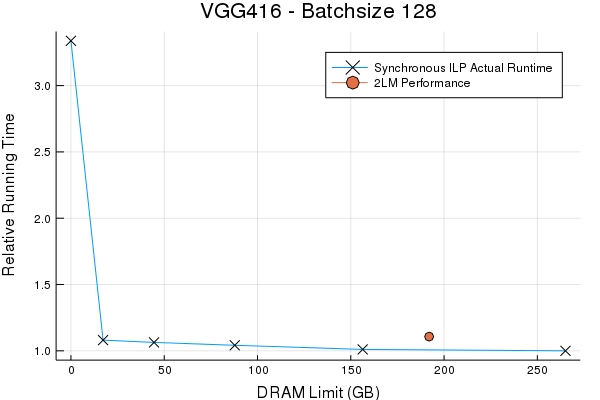

In [21]:
#simple_data = deserialize("serials/inception_v4_3072_simple.jls")
synchronous_data = deserialize("serials/vgg416_128_synchronous.jls")

#=
plot(
    simple_data.sizes_mb ./ 1E3,
    simple_data.predicted_runtimes ./ 1e6,
    marker = :x,
    label = "Simple ILP Predicted Runtime",
    minorgrid = true,
    fmt = :png,
)
plot!(
    simple_data.sizes_mb ./ 1E3,
    simple_data.actual_runtimes,
    marker = :x,
    label = "Simple ILP Actual Runtime"
)
=#
dram_perf = last(synchronous_data.actual_runtimes)
#=
plot(
    synchronous_data.dram_limits ./ 1E3,
    synchronous_data.predicted_runtimes ./ 1e6,
    marker = :x,
    label = "Synchronous ILP Predicted Runtime"
)
=#

plot(
    synchronous_data.dram_limits ./ 1E3,
    #synchronous_data.actual_runtimes ./ last(synchronous_data.actual_runtimes),
    synchronous_data.actual_runtimes ./ dram_perf,
    marker = :x,
    label = "Synchronous ILP Actual Runtime",
    fmt = :png,
)

# Add a dot for 2LM
plot!([192], [261 ./ dram_perf],
    marker = :o,
    label = "2LM Performance"
)
#=
plot!([192], [212],
    marker = :o,
    label = "2LM Performance"
)
=#


title!("VGG416 - Batchsize 128")
ylabel!("Relative Running Time")
xlabel!("DRAM Limit (GB)")

#yaxis!((0, 1.02 * maximum(synchronous_data.actual_runtimes)))